# Conversion Rate #

[Good introductory article on conversion rates](https://www.nngroup.com/articles/conversion-rates/)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree, linear_model, metrics
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, chi2

from IPython.display import Image  
import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('conversion_data.csv')
print(df.head())
print(df.shape)

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0
(316200, 6)


## Exploratory Data Analysis ##

> from the answer's guide ...  
Let’s inspect the data to look for weird behavior/wrong data. Data is never perfect in real life and requires to be cleaned. Often takehome challenges have wrong data which has been put there on purpose.  
** Identifying the wrong data and dealing with it is part of the challenge.**

In [3]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:
df['country'].value_counts()

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

In [5]:
df['source'].value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

#### Removing Erroneous Data ####

> from the answer's guide ...   
* The site is probably a US site, although it does have a large Chinese user base as well 
* User base is pretty young
* Conversion rate at around 3% is industry standard. It makes sense.

In [6]:
df['age'].value_counts(bins=[0, 20, 30, 40, 80, 150], sort=False)

0      35568
20    132283
30    108269
40     40078
80         2
Name: age, dtype: int64

In [7]:
df_new = df[df['age'] < 80].reset_index(drop=True)
df_new.shape

(316198, 6)

#### Checking Relationships between Input Variables and Target ####
> from the answer's guide ...  
Now, let’s quickly investigate the variables and how their distribution differs for the two classes. This will help us understand whether there is any information in our data in the first place and get a sense of the data.  
** Never start by blindly building a machine learning model. Always first get a sense of the data. **

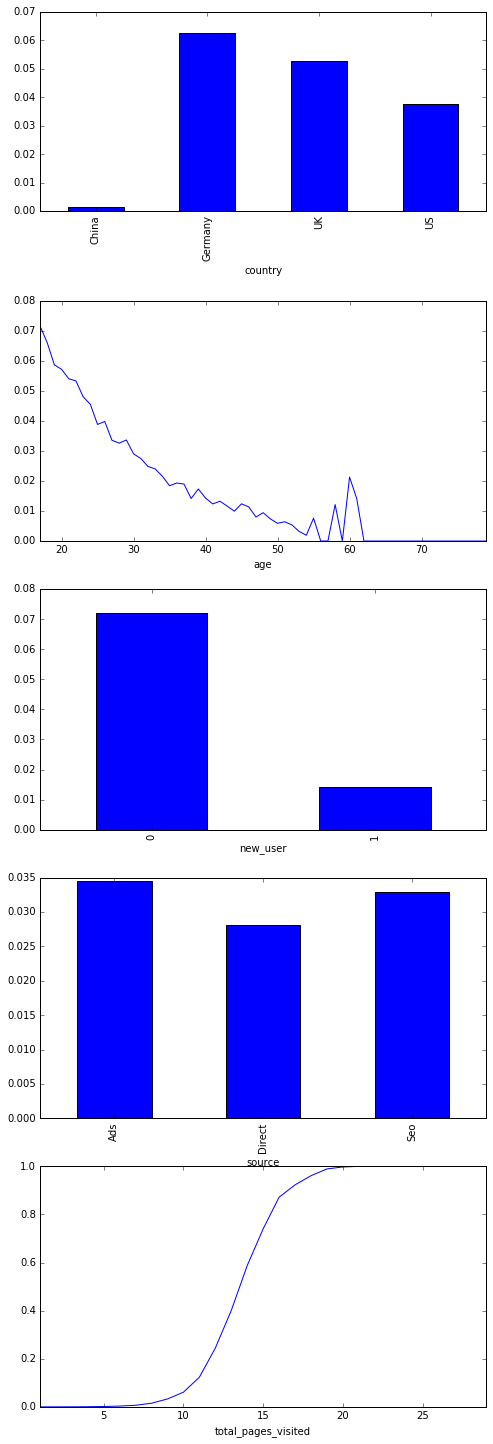

In [8]:
fig, ax = plt.subplots(figsize=(8, 25))
plt.subplot(6,1,1)
df_new.groupby('country')['converted'].mean().plot(kind='bar')
plt.subplot(5,1,2)
df_new.groupby('age')['converted'].mean().plot()
plt.subplot(5,1,3)
df_new.groupby('new_user')['converted'].mean().plot(kind='bar')
plt.subplot(5,1,4)
df.groupby('source')['converted'].mean().plot(kind='bar')
plt.subplot(5,1,5)
df_new.groupby('total_pages_visited')['converted'].mean().plot()
plt.show()

***
## Classification Methods ##

### Featurization ###

In [9]:
feature_names = ['country - UK', 'country - US', 'country - China', 'country - Germany', 'age', 
            'new user', 'source - ads', 'source - seo', 'source - direct', 'total page visited']

In [10]:
# featurize input vectors
countries = df['country'].unique()
sources = df['source'].unique()
vector_len = len(df['country'].unique()) + 1 + 1 + len(df['source'].unique()) + 1

def featurize(row):
    v = np.zeros(vector_len)
    # country feature
    v[:4] = [row['country'] == i for i in countries]
    
    # age feature
    v[4] = row['age']
    
    # if is new user feature
    v[5] = row['new_user']
    
    # source feature
    v[6:9] = [row['source'] == i for i in sources]
    
    # total number of page visited feature
    v[9] = row['total_pages_visited']
    
    return pd.Series(v)

### 1. Stochastic Gradient Descent Classifier ###

In [11]:
# single row testing
row1_features = featurize(df.iloc[0])
print(row1_features)

0     1.0
1     0.0
2     0.0
3     0.0
4    25.0
5     1.0
6     1.0
7     0.0
8     0.0
9     1.0
dtype: float64


In [12]:
# random shuffling to get 30,000 data points
np.random.seed(192837)
df_shuffled = df.iloc[np.random.permutation(len(df))]
df_shuffled.reset_index(drop=True, inplace=True)
df_select = df_shuffled[:100000]

In [13]:
# create predictor values (X: input) and classification result (y: output) arrays
X = df_select.iloc[:,:5]
y = df_select['converted']

In [14]:
X_features = X.apply(featurize, axis=1)

In [15]:
# create train, test and held out datasets
X_train, X_holdout, y_train, y_holdout = train_test_split(X_features, y, test_size=0.25, random_state=424242)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=123456)

print('Selecting a random set of {0} training data, {1} test data, and {2} holdout data'.format(
        X_train.shape[0], X_test.shape[0], X_holdout.shape[0]))

Selecting a random set of 60000 training data, 15000 test data, and 25000 holdout data


In [32]:
# use SDG classifier as a baseline
clf = linear_model.SGDClassifier(random_state=9876543, n_iter=200, penalty='l1')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

print(pd.DataFrame(metrics.confusion_matrix(y_test, pred, labels=[1, 0]), 
                   columns = ['classified: converted', 'classified: non-converted'], 
                   index = ['true: converted', 'true: non-converted']))

# f1 score
metrics.f1_score(y_test, pred)

accuracy:   0.983
                     classified: converted  classified: non-converted
true: converted                        355                        119
true: non-converted                    134                      14392


0.73727933541017643

#### Weight Adjustments ####

In [28]:
class_weights = {0: np.count_nonzero(y==1)/np.count_nonzero(y==0)/10, 1: 1}
print('class weights: ', class_weights)

# use SDG classifier as a baseline
clf = linear_model.SGDClassifier(class_weight = class_weights, random_state=9876543)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

print(pd.DataFrame(metrics.confusion_matrix(y_test, pred, labels=[1, 0]), 
                   columns = ['classified: converted', 'classified: non-converted'], 
                   index = ['true: converted', 'true: non-converted']))

# f1 score
metrics.f1_score(y_test, pred)

class weights:  {0: 0.003332472229398088, 1: 1}
accuracy:   0.874
                     classified: converted  classified: non-converted
true: converted                        460                         14
true: non-converted                   1882                      12644


0.32670454545454547

#### Feature Importance ####

In [18]:
feature_weights = list(zip(feature_names, abs(clf.coef_[0]), np.sign(clf.coef_[0])))

In [19]:
sorted(feature_weights,key=lambda x: x[1], reverse=True)

[('total page visited', 3.7222625768050395, 1.0),
 ('new user', 3.3802180837153286, -1.0),
 ('country - China', 2.5798256105787996, -1.0),
 ('source - seo', 0.8408785105706561, -1.0),
 ('age', 0.53696073672873457, -1.0),
 ('source - direct', 0.52645666422692616, -1.0),
 ('country - UK', 0.46800839675931483, 1.0),
 ('country - Germany', 0.43832595967439231, 1.0),
 ('country - US', 0.26866446212629624, 1.0),
 ('source - ads', 0.037491617221879832, -1.0)]

### 2. Decision Tree Classifier ###

In [31]:
# Classifier
clf = tree.DecisionTreeClassifier(random_state=1993955975, max_depth=15, min_samples_split=10)

# for visualization only
# clf = tree.DecisionTreeClassifier(random_state=1993955975, 
#                                   max_depth=3, min_samples_split=10, class_weight = class_weights)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

# Confusion Matrix
print(pd.DataFrame(metrics.confusion_matrix(y_test, pred, labels=[1, 0]), 
                   columns = ['classified: converted', 'classified: non-converted'], 
                   index = ['true: converted', 'true: non-converted']))

# f1 score
metrics.f1_score(y_test, pred)

accuracy:   0.985
                     classified: converted  classified: non-converted
true: converted                        327                        147
true: non-converted                     83                      14443


0.73981900452488691

#### Visualization: Top 3 Features of the Tree ####

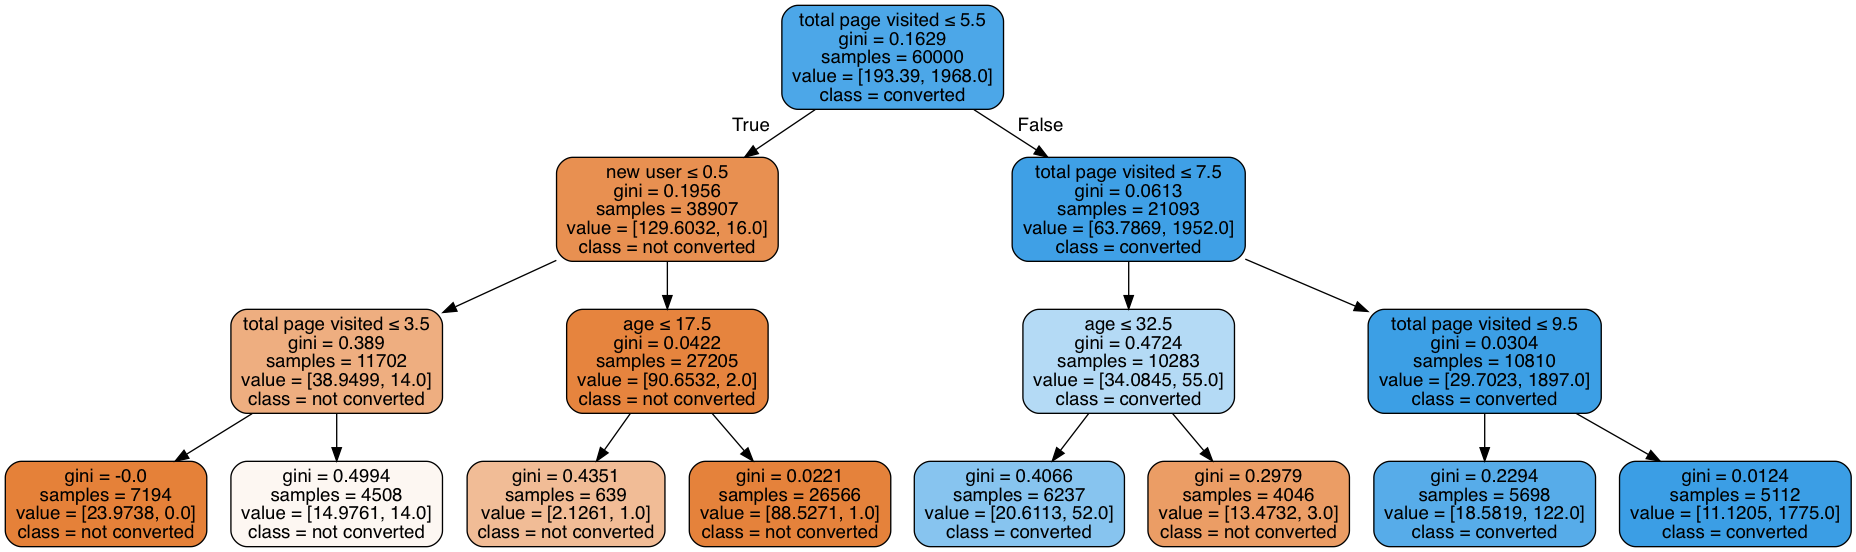

In [30]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_names,
                                class_names=['not converted', 'converted'],
                                filled=True, rounded=True, special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### Feature Importance ####

In [22]:
feature_weights = list(zip(feature_names, abs(clf.feature_importances_)))

In [23]:
clf.feature_importances_

array([ 0.00520294,  0.0065463 ,  0.03974727,  0.00419384,  0.08537363,
        0.04677557,  0.00622271,  0.00542255,  0.00893125,  0.79158395])

In [24]:
sorted(feature_weights,key=lambda x: x[1], reverse=True)

[('total page visited', 0.79158395136808424),
 ('age', 0.085373632403278568),
 ('new user', 0.046775566668928611),
 ('country - China', 0.039747268966047682),
 ('source - direct', 0.0089312531058659533),
 ('country - US', 0.0065462963741069764),
 ('source - ads', 0.0062227144898055944),
 ('source - seo', 0.0054225451089420403),
 ('country - UK', 0.0052029359732053485),
 ('country - Germany', 0.0041938355417349502)]

### 3. Gradient Boosting Classifier ###

In [25]:
clf = GradientBoostingClassifier(random_state=1993955975, max_depth=10, n_estimators=100)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

# Confusion Matrix
print(pd.DataFrame(metrics.confusion_matrix(y_test, pred, labels=[1, 0]), 
                   columns = ['classified: converted', 'classified: non-converted'], 
                   index = ['true: converted', 'true: non-converted']))

accuracy:   0.983
                     classified: converted  classified: non-converted
true: converted                        327                        147
true: non-converted                    105                      14421


#### Visualization: Partial Dependency Plot ####

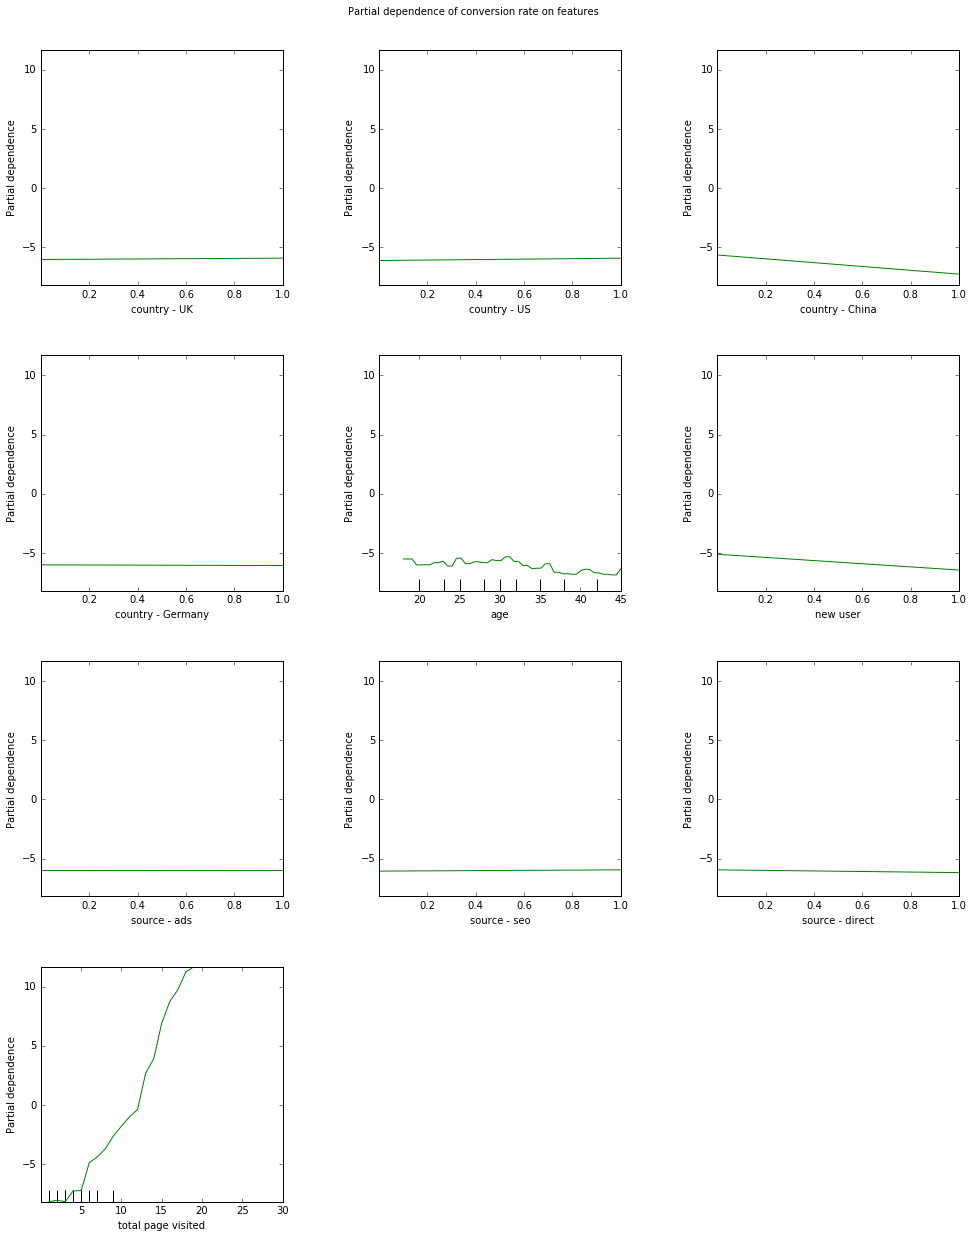

In [26]:
features = list(range(10))
fig, axs = plot_partial_dependence(clf, X_train, features,
                                   feature_names=feature_names,
                                   n_jobs=2, grid_resolution=50, figsize=(15, 20))
fig.suptitle('Partial dependence of conversion rate on features')
plt.subplots_adjust(top=0.95)  # tight_layout causes overlap with suptitle

plt.show()

***

#### Feature Importance Alternative Measure ####

In [27]:
selector = SelectKBest(chi2, k=5)
selector.fit(X_train, y_train)
important_features_idx = list(selector.get_support(indices=True))
print([feature_names[i] for i in important_features_idx])

['country - UK', 'country - China', 'age', 'new user', 'total page visited']
